<a href="https://colab.research.google.com/github/Bhupinder-2004/CODINGSAMURAI/blob/main/Stock_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Using column 'Close' with 1760 records.


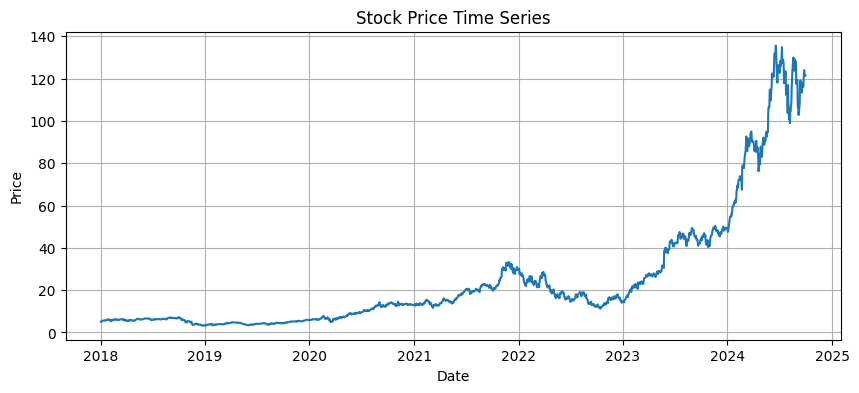

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

path = "NVIDIA_STOCK.csv"
df = pd.read_csv(path)

date_col = None
for col in df.columns:
    parsed = pd.to_datetime(df[col], errors='coerce')
    if parsed.notna().sum() > 0.6 * len(df):
        date_col = col
        df[col] = parsed
        break

if date_col is None:
    raise ValueError("Could not detect a date column in the CSV.")

df = df.set_index(date_col)
df = df.sort_index()

for col in df.columns:
    df[col] = df[col].astype(str).str.replace(r'[^0-9.\-]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

close_col = None
for c in ['Close', 'Adj Close', 'Price']:
    if c in df.columns:
        close_col = c
        break
if close_col is None:
    close_col = df.select_dtypes(include=[np.number]).columns[-1]

series = df[close_col].dropna().asfreq('B')
series = series.fillna(method='ffill')

print(f" Using column '{close_col}' with {len(series)} records.")

plt.figure(figsize=(10,4))
plt.plot(series)
plt.title("Stock Price Time Series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
 LSTM Test RMSE: 4.15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

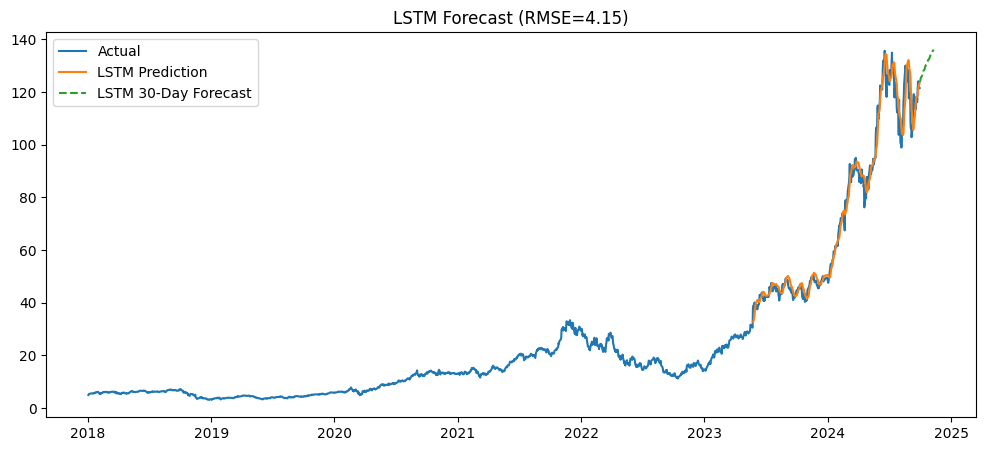

💾 Forecasts saved to Stock_30Day_Forecast.csv

📋 Summary:
LSTM RMSE: 4.15

✅ Done! You can open 'Stock_30Day_Forecast.csv' to see future predictions.


In [5]:
n = len(series)
test_size = int(0.2 * n)
train, test = series[:-test_size], series[-test_size:]


#LSTM Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))

lookback = 30
X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i, 0])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = len(X) - test_size
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(lookback, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=0)

pred_test_scaled = model.predict(X_test)
pred_test = scaler.inverse_transform(pred_test_scaled)
lstm_rmse = sqrt(mean_squared_error(series[-len(pred_test):], pred_test))
print(f" LSTM Test RMSE: {lstm_rmse:.2f}")

future_preds = []
last_seq = scaled[-lookback:].reshape(1, lookback, 1)
for _ in range(future_steps):
    pred = model.predict(last_seq)[0,0]
    future_preds.append(pred)
    last_seq = np.append(last_seq[:,1:,:], [[[pred]]], axis=1)

pred_future_lstm = scaler.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()

plt.figure(figsize=(12,5))
plt.plot(series.index, series, label='Actual')
plt.plot(test.index, pred_test, label='LSTM Prediction')
plt.plot(future_index, pred_future_lstm, '--', label='LSTM 30-Day Forecast')
plt.legend()
plt.title(f"LSTM Forecast (RMSE={lstm_rmse:.2f})")
plt.show()

# Save Forecasts

forecast_df = pd.DataFrame({
    'Date': future_index,
    'ARIMA_Forecast': pred_future_arima.values,
    'LSTM_Forecast': pred_future_lstm
})
forecast_df.to_csv("Stock_30Day_Forecast.csv", index=False)
print("💾 Forecasts saved to Stock_30Day_Forecast.csv")

# Summary
print("\n📋 Summary:")
print(f"LSTM RMSE: {lstm_rmse:.2f}")
print("\n✅ Done! You can open 'Stock_30Day_Forecast.csv' to see future predictions.")
